### This notebook fits polynomials to the parsec isochrone data, picks the polynomial function that minimizes the frobenius norm of the residuals, calculates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr
import statsmodels.api as sm
import itertools as it

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

In [2]:

data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [3]:
u_des = objs['DECAM_U']
g_des = objs['DES_G']
r_des = objs['DES_R']
i_des = objs['DES_I']
z_des = objs['DES_Z']
feh_des = objs['FEH']
u_g_des = u_des - g_des
g_r_des = g_des - r_des


In [4]:
u_g_des = u_g_des + .3

In [5]:
#apply shift found in isochrone_minimize_residuals_01OCT2019
u_g_dex = u_g_des - .005
g_r_dex = g_r_des - .005

In [6]:
#cuts and shifts from isochrone_minimize_residuals_01OCT2019
#reduce area to around selection box
selected = np.where((u_g_des>=0.4)&(u_g_des<=1.3)&(g_r_des>=0)&(g_r_des<=0.4))
u_g_des = u_g_des[selected]
g_r_des = g_r_des[selected]
feh_des = feh_des[selected]






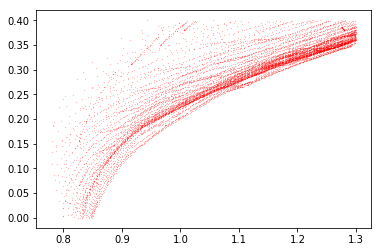

In [7]:
plt.scatter(u_g_des,g_r_des,c='r',s=.01)

### fit polynomials to above parsec isochrone data

In [8]:
#following: https://github.com/JoshuaPovick/Magellanic_Ages/blob/master/NEW_PARSEC.ipynb
#Create a list of all possible models
y1 = u_g_des
y2 = g_r_des
y12 = np.multiply(y1,y2)
y1sq = y1**2
y2sq = y2**2
y1sq2 = np.multiply(y1sq,y2)
y2sq1 = np.multiply(y2sq,y1)
y1th = y1**3
y2th = y2**3

models = []
models_str = []
all_var_str = ['y1','y2','y12','y1sq','y2sq','y1sq2','y2sq1','y1th','y2th']
all_var = [y1,y2,y12,y1sq,y2sq,y1sq2,y2sq1,y1th,y2th]

In [9]:
for i in range(2, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))

In [10]:
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2':
        idx.append(j)
models = np.array(models)[idx]
models_str = np.array(models_str)[idx]

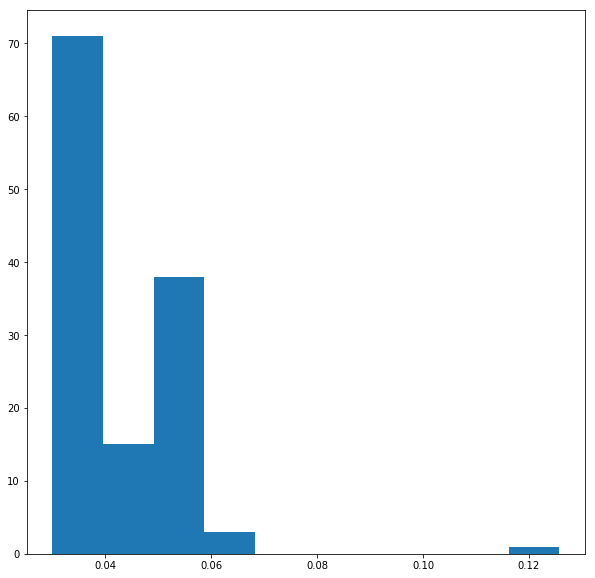

0.030007038910651058
[array(['y1', 'y2', 'y1sq', 'y1sq2', 'y2sq1', 'y1th', 'y2th'], dtype='<U5')]
[array([ -49.27522572,  125.01890136,  -10.81052376, -102.59014183,
         17.52793863,  -23.75625663,   26.27050131,   -3.16243291])]


In [11]:
#fit all models
model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(feh_des,pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - feh_des
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(np.array(models_str)[best])
print(np.asarray(model_params)[best])


In [35]:

#evaluate each polynomial for:
#x= u_g_des
#y= g_r_des
fitted = []

for i in np.arange(0,len(model_params)):
    temp = []
    temp.append(model_params[i][0]*(np.ones(len(u_g_des))))
    for j in np.arange(1,len(model_params[i])):
        if models_str[i][(j-1)] == 'y1':
            temp.append((u_g_des*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y2':
            temp.append((g_r_des*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y12':
            temp.append((u_g_des*g_r_des*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y1sq':
            temp.append((u_g_des**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2sq':
            temp.append((g_r_des**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y1sq2':
            temp.append(g_r_des*(u_g_des**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2sq1':
            temp.append((u_g_des*model_params[i][j])*(g_r_des**2))
        elif models_str[i][(j-1)] == 'y1th':
            temp.append((u_g_des**3)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2th':
            temp.append((g_r_des**3)*model_params[i][j])
    #print(temp)
    #print(len(temp))
    sums = temp[0]
    for k in np.arange(1,len(temp)):
        sums += temp[k]
    fitted.append((sums))
        
        
        

### Calculate frobenius norm ( square root of sum of squares ) the residuals

In [13]:
norm = []
for model in fitted:
    residuals = feh_des - model
    temp = 0
    for element in residuals:
        temp += (element**2)
    norm.append(np.sqrt(np.sum(temp)))
        
        
        

### Plot histogram of norm of the residuals

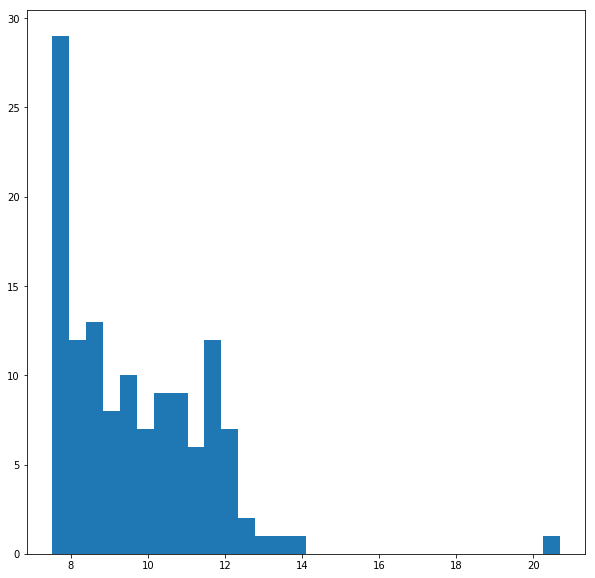

In [16]:
plt.figure(figsize=[10,10])
plt.hist(norm,bins=30)
plt.show()

In [33]:
small, = np.where(np.asarray(norm)< 7.6)

### Plot residuals with norm < 7.6

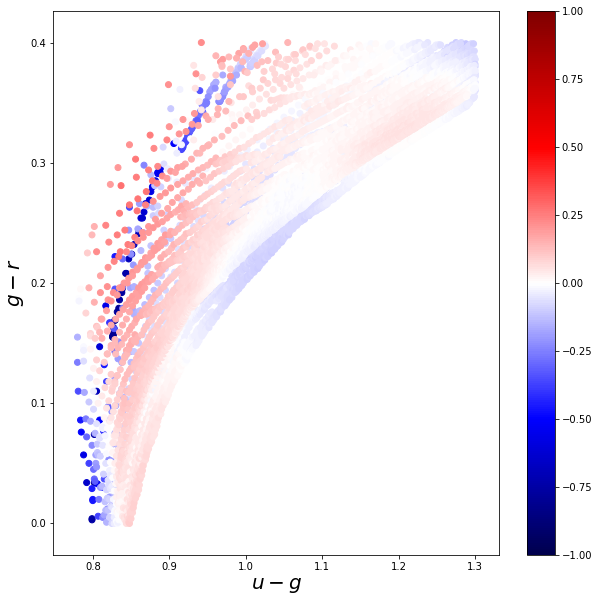

[-2.52539456 -2.51278098 -2.51485104 ...  0.18403632  0.20909506
  0.20501737]
117
['y1' 'y2' 'y1sq' 'y2sq' 'y2sq1' 'y1th' 'y2th']
[-44.03185347 107.60521475   0.2232003  -86.69026822 -37.87735182
  34.53795127  23.21546675 -24.56313394]


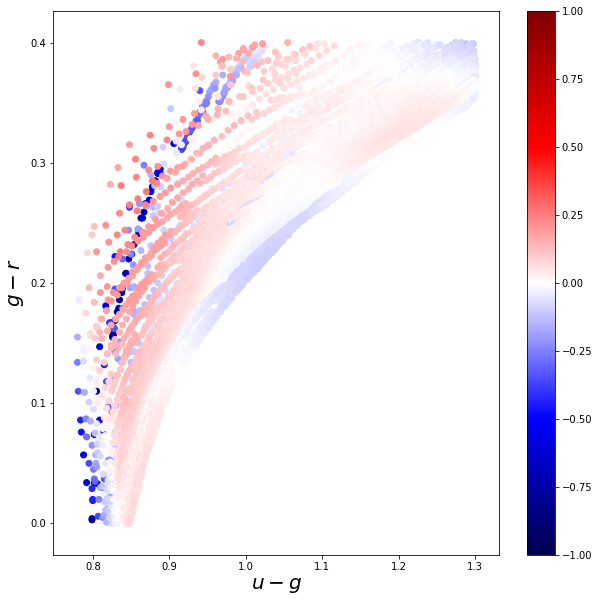

[-2.53023939 -2.50635378 -2.49276792 ...  0.18094797  0.20524294
  0.20130713]
123
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y2sq1' 'y1th' 'y2th']
[-42.57764261 102.25207356   5.20125804  -6.48301499 -80.91300961
 -42.94294321  44.37612238  21.49242558 -29.61600327]


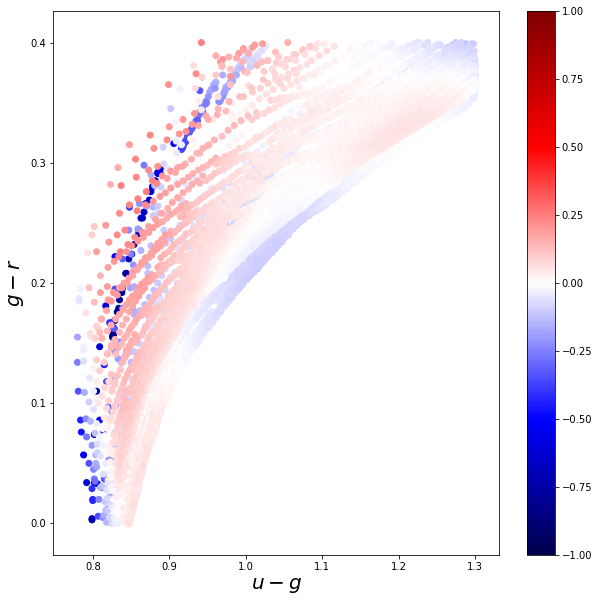

[-2.54948701 -2.51920595 -2.49124565 ...  0.179826    0.20538638
  0.20155857]
126
['y1' 'y2' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y1th' 'y2th']
[-41.72344293  99.90563197   5.46029773 -79.78463426 -54.95145296
  -8.7798619   63.2525474   22.05412176 -37.23530549]


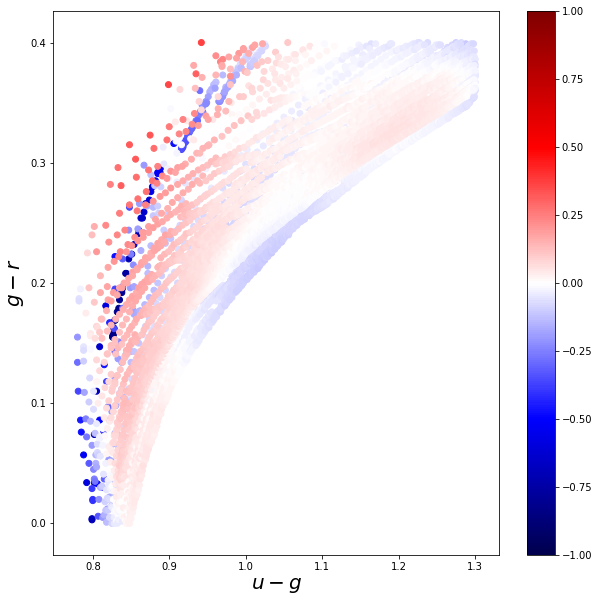

[-2.67195475 -2.66335094 -2.62137306 ...  0.19096815  0.23137867
  0.22752487]
127
['y1' 'y2' 'y12' 'y1sq' 'y2sq' 'y1sq2' 'y2sq1' 'y1th' 'y2th']
[ -44.27677739  115.67737032  -24.5631504    93.56679366 -108.01788098
 -118.19369438  -78.89488701  150.57376231   37.64771891  -65.50782695]


In [34]:
#plot residuals 

for index in small:
    plt.figure(figsize=(10,10))
    plt.scatter(u_g_des,g_r_des,c=(feh_des-fitted[index]),cmap='seismic',vmin=-1,vmax=1)
    plt.colorbar()
    plt.xlabel('$u-g$',fontsize=20)
    plt.ylabel('$g-r$',fontsize=20)
    plt.show()
    print(fitted[index])
    print(index)
    print(models_str[index])
    print(model_params[index])
    

### Look at the residuals with the minimum norm

In [19]:
minimum = np.where(norm==np.array(norm).min())

In [20]:
minimum

(array([127]),)

### The minimum norm of residuals is the last plot above. Investigating the residuals of this polynomial(u_g_des,g_r_des) more

In [27]:
x = np.arange(-4,1,.001)

In [28]:
len(x)

5000

In [29]:
y = (np.nanmedian(delta))*np.ones(5000)

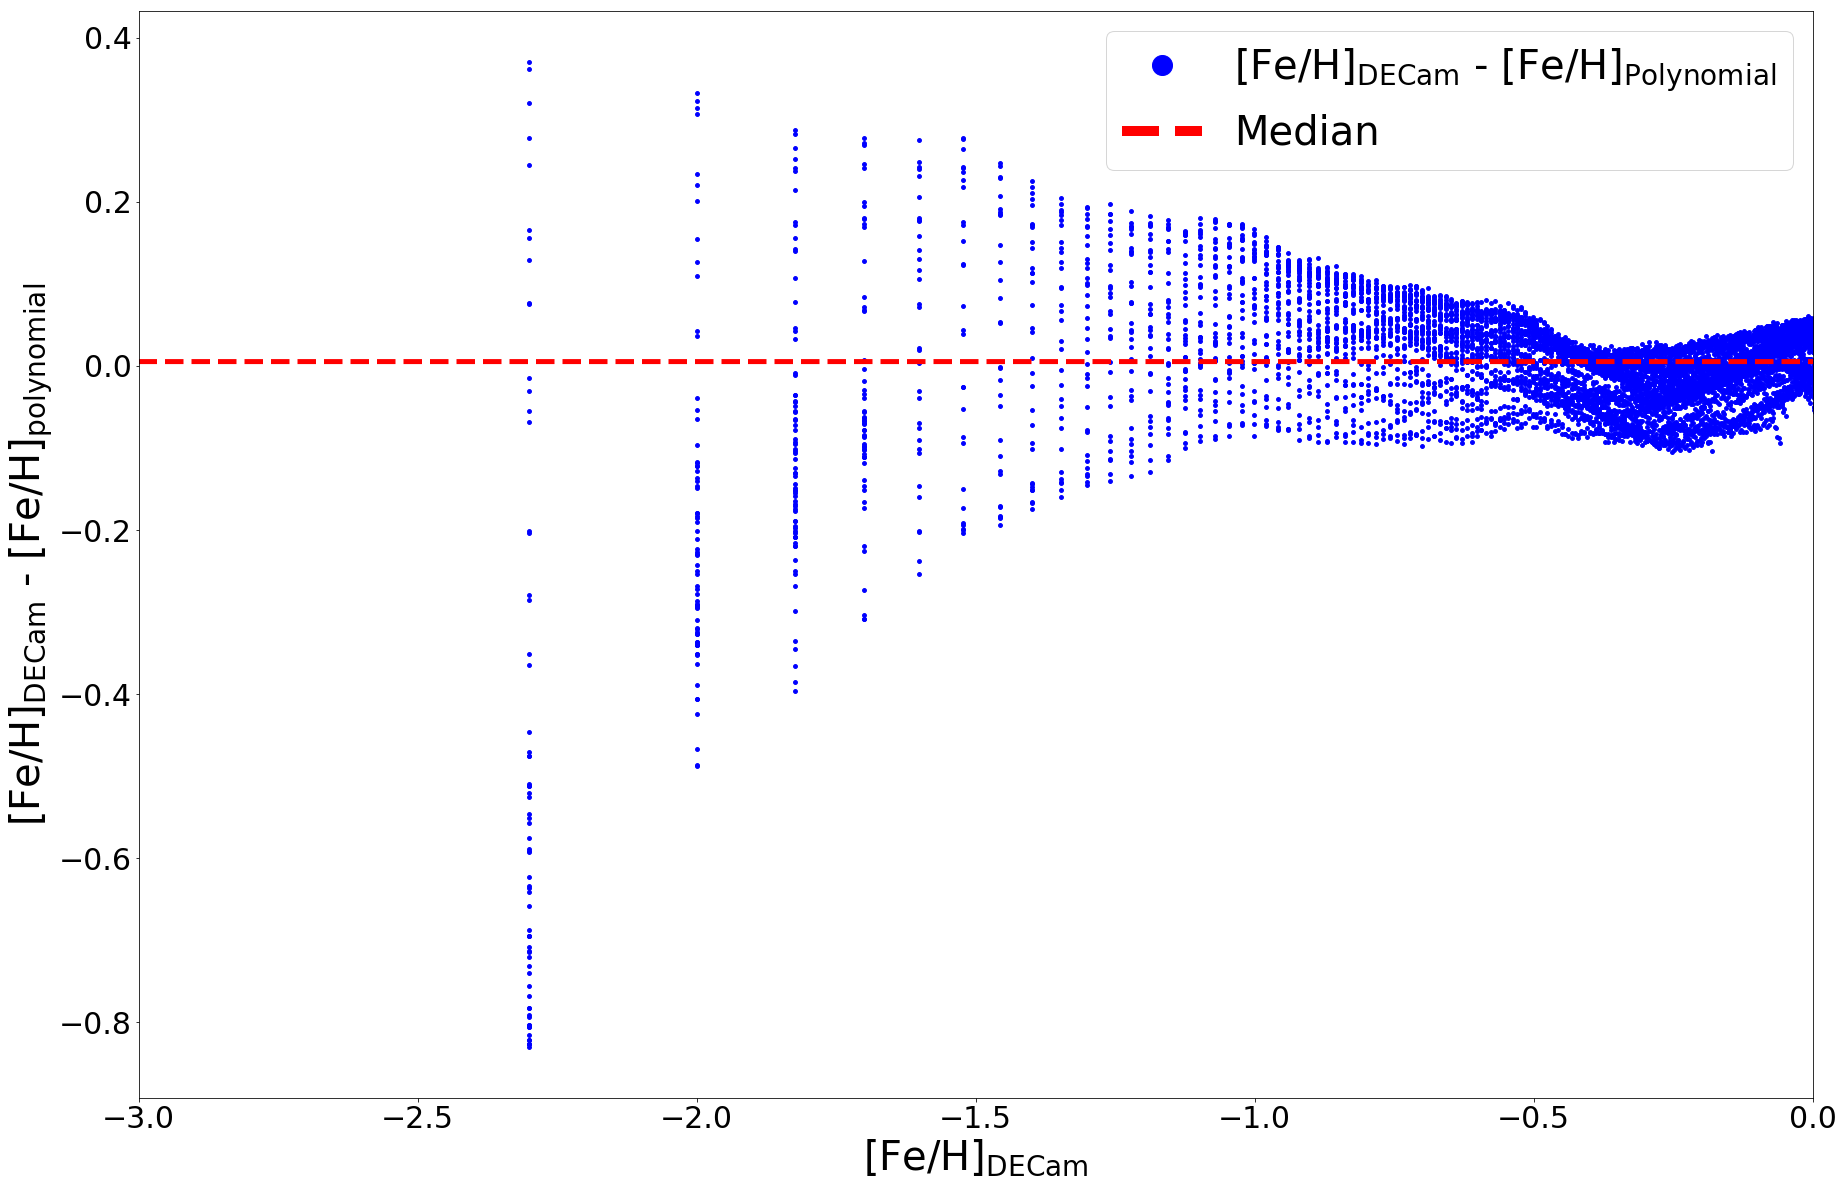

In [30]:
blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{Polynomial}$')
red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

delta = feh_des - fitted[127]

fig, ax = plt.subplots(figsize=(30,20))

ax.scatter(feh_des,delta,c='b',s=15)
plt.xlabel('[Fe/H]$_\mathregular{DECam}$',fontsize=40)
plt.ylabel('[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{polynomial}$',fontsize=40)
plt.plot(x,y,'--',c='r',linewidth=5,label='Median')
ax.set_xlim(-3,0)
        
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(handles=[blue,red],fontsize=40)


### Median of above residuals

In [25]:
np.nanmedian(delta)

0.005307141493773315